In [180]:
import _pickle as cPickle
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import as_strided
from scipy.signal import convolve2d

from PIL import Image
%matplotlib inline

plt.rcParams['image.cmap'] = 'viridis'

In [2]:
def read_images(folder):
    fnames = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    images = [np.array(Image.open(os.path.join(folder, f))) for f in fnames]
    return np.array(images)

data = read_images('cifar/')

In [153]:
def hog_tensor_fold(a, block_size, stride = 1):
    size_t   = a.dtype.itemsize    
    n_block  = block_size
    n_stride = stride
    n_batch, n_height, n_width, n_channel = a.shape
    
    strides = ( n_channel * n_height * n_width * size_t, 
                n_channel * n_stride * n_width * size_t, 
                n_channel * n_stride * size_t, 
                n_channel * n_width  * size_t, 
                n_channel * size_t, 
                size_t )
    
    shape   = ( n_batch, 
               (n_height - n_block) // n_stride + 1, 
                n_width // n_stride, 
                n_block, 
                n_block, 
                n_channel )
    
    result = as_strided(a, strides=strides, shape=shape)
    result = result[:, :, :(n_width - n_block)//n_stride + 1, :, :, :]
    
    #result = result.reshape((result.shape[0], 
    #                         result.shape[1]*result.shape[2],
    #                         result.shape[3],
    #                         result.shape[4],
    #                         result.shape[5]))
    
    return result

In [177]:
def hog_tensor_fold(img, block_size = 16, cell_size = 8, stride = 8):    
    size_t   = a.dtype.itemsize    
    n_block  = block_size
    n_cell   = cell_size
    n_stride = stride
    n_batch, n_height, n_width, n_channel = img.shape
    
    if (n_width - n_block) % n_stride != 0:
        raise ValueError("`img.shape[2] - block_size` must be a multiple of `stride`")
    if (n_height - n_block) % n_stride != 0:
        raise ValueError("`img.shape[1] - block_size` must be a multiple of `stride`")
    if n_block % n_cell != 0:
        raise ValueError("`block_size` must be a multiple of `cell_size`")
    
    strides = ( n_channel * n_height * n_width * size_t, # batch dimension
                n_channel * n_stride * n_width * size_t, # block Y dimension   within an image
                n_channel * n_stride * size_t,           # block X dimension   within an image
                n_channel * n_cell * n_width * size_t,   # cell Y dimension    within a block
                n_channel * n_cell * size_t,             # cell X dimension    within a block
                n_channel * n_width  * size_t,           # spatial Y dimension within a cell
                n_channel * size_t,                      # spatial X dimension within a cell
                size_t )                                 # channel dimension
    
    shape   = ( n_batch, 
               (n_height - n_block) // n_stride + 1, 
                n_width // n_stride, 
                n_block // n_cell, 
                n_block // n_cell, 
                n_cell,
                n_cell,
                n_channel )
    
    result = as_strided(img, strides=strides, shape=shape)
    result = result[:, :, :(n_width - n_block)//n_stride + 1, :, :, :]
    result = result.reshape((result.shape[0],
                             result.shape[1]*result.shape[2],
                             result.shape[3]*result.shape[4],
                             result.shape[5],
                             result.shape[6],
                             result.shape[7]))
    
    return result

In [201]:
kernel = np.array([[-1,0,1]])
X = data[:10]

k = 4
g_x = np.stack([convolve2d(X[k,:,:,0], kernel, mode = 'same'),
                convolve2d(X[k,:,:,1], kernel, mode = 'same'),
                convolve2d(X[k,:,:,2], kernel, mode = 'same')], axis=-1)

g_y = np.stack([convolve2d(X[k,:,:,0], kernel.T, mode = 'same'),
                convolve2d(X[k,:,:,1], kernel.T, mode = 'same'),
                convolve2d(X[k,:,:,2], kernel.T, mode = 'same')], axis=-1)

g_norm = np.sqrt(z_x**2 + z_y**2)
#g_idx = np.argmax(z_a, axis = 2)

#g_mag = g_norm[]

#plt.imshow(g_mag)

In [205]:
a = np.arange(9).reshape((3,3))
a.take([0,2], axis = 1)

array([[0, 2],
       [3, 5],
       [6, 8]])

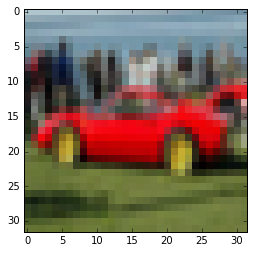

In [179]:
#a = X[0].copy() #np.arange(64).reshape((8,8))
Z = hog_tensor_fold(X.copy(), 16, 8, 16)
#Z = Z.reshape(10,9,16,16,3)

k = 0

W = np.vstack([
        np.hstack([
            np.vstack([
                np.hstack([Z[k,0,0],Z[k,0,1]]), 
                np.hstack([Z[k,0,2],Z[k,0,3]])
            ]),
            np.vstack([
                np.hstack([Z[k,1,0],Z[k,1,1]]), 
                np.hstack([Z[k,1,2],Z[k,1,3]])
            ])
        ]),
        np.hstack([
            np.vstack([
                np.hstack([Z[k,2,0],Z[k,2,1]]),
                np.hstack([Z[k,2,2],Z[k,2,3]])
            ]),
            np.vstack([
                np.hstack([Z[k,3,0],Z[k,3,1]]), 
                np.hstack([Z[k,3,2],Z[k,3,3]])
            ])
        ])
    ])

plt.imshow(W, interpolation='nearest')
#Z.shape

In [167]:
Z.shape

(10, 2, 2, 2, 2, 8, 8, 3)

In [98]:
X[0,:,:,0]

array([[176, 174, 175, ..., 114, 112, 110],
       [148, 143, 142, ..., 127, 131, 134],
       [114, 115, 117, ..., 146, 151, 151],
       ..., 
       [ 54,  41,  47, ..., 116, 113, 106],
       [ 73,  76,  78, ..., 114, 109, 109],
       [101, 100,  98, ..., 111, 114, 114]], dtype=uint8)